# Preliminary Results

## Load Libraries

In [1]:
## code to get rid of warnings
defaultW <- getOption("warn") 
options(warn = -1) 
##

suppressPackageStartupMessages(library(tidyverse))
library(repr)
library(digest)
library(infer)
suppressPackageStartupMessages(library(gridExtra))
library(cowplot)

## Data Intake and Pre-Processing

First, we will read in the dataset. The code here assumes you've downloaded the dataset and placed them into a data folder. If you would like to run our code and follow along, please clone our GitHub repository [here](https://github.com/KevinSaigon/stat-201-project)

In [2]:
data <- read.csv(file = "data/athlete_events.csv")
# website says "Demonstrate that the dataset can be read from the web into R." - is local files okay? Ask on Monday

We will then do some pre-processing to get rid of any athlete whose age is is not known as well as filter out ones who did not win gold medals. 

The next step was then to only count first-time wins for multiple-time medal winners (i.e Michael Phelps). The code below essentially only keep the first occurrence of an athlete's ID, and since we sorted the dataframe by Year, this equates to the athlete's first time winning the gold medal.

In [57]:
processed_df <- data[order(data$Year),]  %>% 
    filter(!is.na(Age)) %>% # get rid of NA/Age
    filter(!is.na(Medal))   # get rid of anyone who didn't win a medal either

first_time_only <- processed_df[match(unique(processed_df$ID), processed_df$ID),] # only first time winners now, if they won a second time, it was excluded
    
head(first_time_only)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
4,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
6,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
8,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
9,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


Next, we will split the dataset by their Season, the winter Olympics vs the summer Olympics

In [4]:
winter_df <- first_time_only %>% 
    filter(Season == "Winter")

summer_df <- first_time_only %>% 
    filter(Season == "Summer")

head(winter_df)
head(summer_df)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,391,Clarence John Abel,M,23,185,102,United States,USA,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Silver
2,1341,Johan Petter hln (Andersson-),M,44,NA,NA,Sweden,SWE,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Silver
3,3872,William Harding Anderson,M,22,NA,NA,Great Britain,GBR,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
4,4060,Georges Jules Andr,M,47,NA,NA,France,FRA,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Bronze
5,5232,Thomas Alfred Arnold,M,22,NA,NA,Great Britain-1,GBR,1924 Winter,1924,Winter,Chamonix,Bobsleigh,Bobsleigh Men's Four/Five,Silver
6,5932,Alfred Aufdenblatten,M,26,NA,NA,Switzerland,SUI,1924 Winter,1924,Winter,Chamonix,Military Ski Patrol,Military Ski Patrol Men's Military Ski Patrol,Gold


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
3,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
4,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
5,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
6,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


## Calculations 

If we are assuming that this dataset is 100% accurate and thus represent that entire population of all Olympic participants, then we could consider the dataset a population, and thus uncertainty would be 0%. However, in reality, if we were trying to gather this dataset ourselves, it is extremely unlikely as well as unfeasible to collect so many data points. Realistically, we would take a sample of this population, so we will will take an initial sample of 3000

In [5]:
set.seed(42069)

winter_sample <- winter_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

summer_sample <- summer_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

head(winter_sample)

ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
85481,Michael Neumayer,M,31,180,60,Germany,GER,2010 Winter,2010,Winter,Vancouver,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Silver
25759,Vitaly Semyonovich Davydov,M,24,182,69,Soviet Union,URS,1964 Winter,1964,Winter,Innsbruck,Ice Hockey,Ice Hockey Men's Ice Hockey,Gold
3951,Lina Marie Andersson,F,24,158,58,Sweden,SWE,2006 Winter,2006,Winter,Torino,Cross Country Skiing,Cross Country Skiing Women's Team Sprint,Gold
44916,Veikko Johannes Hakulinen,M,27,173,66,Finland,FIN,1952 Winter,1952,Winter,Oslo,Cross Country Skiing,Cross Country Skiing Men's 50 kilometres,Gold
42073,Amlie Goulet-Nadon,F,19,165,57,Canada,CAN,2002 Winter,2002,Winter,Salt Lake City,Short Track Speed Skating,"Short Track Speed Skating Women's 3,000 metres Relay",Bronze
49094,Lukas Hofer,M,24,175,62,Italy,ITA,2014 Winter,2014,Winter,Sochi,Biathlon,Biathlon Mixed 2 x 6 kilometres and 2 x 7.5 kilometres Relay,Bronze


From this, we can calculate our estimates of the mean for each season

In [54]:
winter_mean_estimate <- mean(winter_sample$Age)
summer_mean_estimate <- mean(summer_sample$Age)

cat("Winter Mean Estimate:", winter_mean_estimate, "\nSummer Mean Estimate:", summer_mean_estimate)

Winter Mean Estimate: 25.165 
Summer Mean Estimate: 25.078

## Sampling

Then, we'll perform bootstrapping or resampling with replacement to calculate uncertainty later on

In [7]:
set.seed(42069)

winter_bootstrap <- winter_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)

summer_bootstrap <- summer_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)


head(summer_bootstrap)

replicate,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,59251,Ilias Khatzipavlis,M,23,183,92,Greece,GRE,1972 Summer,1972,Summer,Munich,Sailing,Sailing Mixed One Person Dinghy,Silver
1,26210,"Regina Constance ""Reggie"" de Jong",F,16,168,55,Netherlands,NED,1980 Summer,1980,Summer,Moskva,Swimming,Swimming Women's 4 x 100 metres Freestyle Relay,Bronze
1,63441,Andriy Kovalenko,M,21,190,92,Unified Team,EUN,1992 Summer,1992,Summer,Barcelona,Water Polo,Water Polo Men's Water Polo,Bronze
1,33767,Otto Fahr,M,19,NA,NA,Germany,GER,1912 Summer,1912,Summer,Stockholm,Swimming,Swimming Men's 100 metres Backstroke,Silver
1,69088,Melanie Leupolz,F,22,173,52,Germany,GER,2016 Summer,2016,Summer,Rio de Janeiro,Football,Football Women's Football,Gold
1,100141,Michael Reusch,M,22,NA,NA,Switzerland,SUI,1936 Summer,1936,Summer,Berlin,Gymnastics,Gymnastics Men's Team All-Around,Silver


Now, we will calculate the sample mean for each sample.

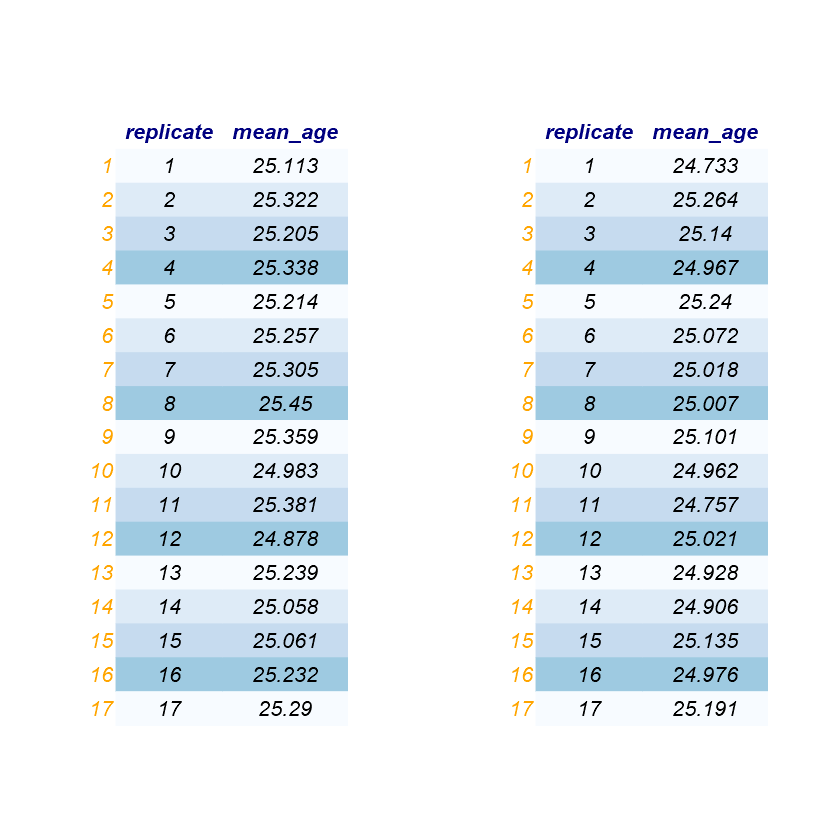

In [56]:
winter_resampled_means <- winter_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

summer_resampled_means <- summer_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

## display code to make tables look pretty - can ignore
tt3 <- ttheme_minimal(
  core=list(bg_params = list(fill = blues9[1:4], col=NA),
            fg_params=list(fontface=3)),
  colhead=list(fg_params=list(col="navyblue", fontface=4L)),
  rowhead=list(fg_params=list(col="orange", fontface=3L)))

grid.arrange(
    tableGrob(head(winter_resampled_means, 17), theme = tt3),
    tableGrob(head(summer_resampled_means, 17), theme = tt3),
    nrow = 1)

## Visualizations

Let's first remind ourselves of our calculated estimates

In [46]:
Name <- c("Winter Mean Estimate", "Summer Mean Estimate")
Values <- c(winter_mean_estimate, summer_mean_estimate)

tab <- data.frame(Name, Values)
tab

Name,Values
<chr>,<dbl>
Winter Mean Estimate,25.165
Summer Mean Estimate,25.078


In [48]:
# function to plot histogram with a vertical line indicating the mean, 
# with or without the Gaussian curve
# @params: 
#     df: a dataframe
#     col: column name (string)
#     bin_width: int
#     is_bellcurve: whether you want the bell curve option or not (bool),
#                   default is FALSE
# @return: a plot object so that you can customize the title and axis with labs()

plot_histogram <- function(df, col, bin_width, is_bellcurve) {
    plot <- df %>%
        ggplot(aes(x=pull(df, col))) +
#         geom_vline(xintercept = mean(pull(df, col), color="blue")) +
        geom_text(aes(x = mean(pull(df, col)), 
                      y=0,
                      label=mean(pull(df, col)),
                      hjust=0,
                      vjust=1),
                  color="blue") +
        xlab(col)
        
    if (missing(is_bellcurve) || (is_bellcurve == FALSE)) {
        plot <- plot + 
        geom_histogram(binwidth=bin_width, color="white", alpha=0.5) +
        ylab("Count") +
        ggtitle(paste0("Distribution of ", col))
    } else {
        plot <- plot +
        geom_histogram(aes(y=..density..), binwidth=bin_width, color="white", alpha=0.5) +
        stat_function(fun=dnorm, color="red", args=list(mean=mean(pull(df, col)), 
                                                        sd=sd(pull(df, col)))) +
        ylab("Probability density") +
        ggtitle(paste0("Distribution of ", col))
    }
    
    return (plot)
}

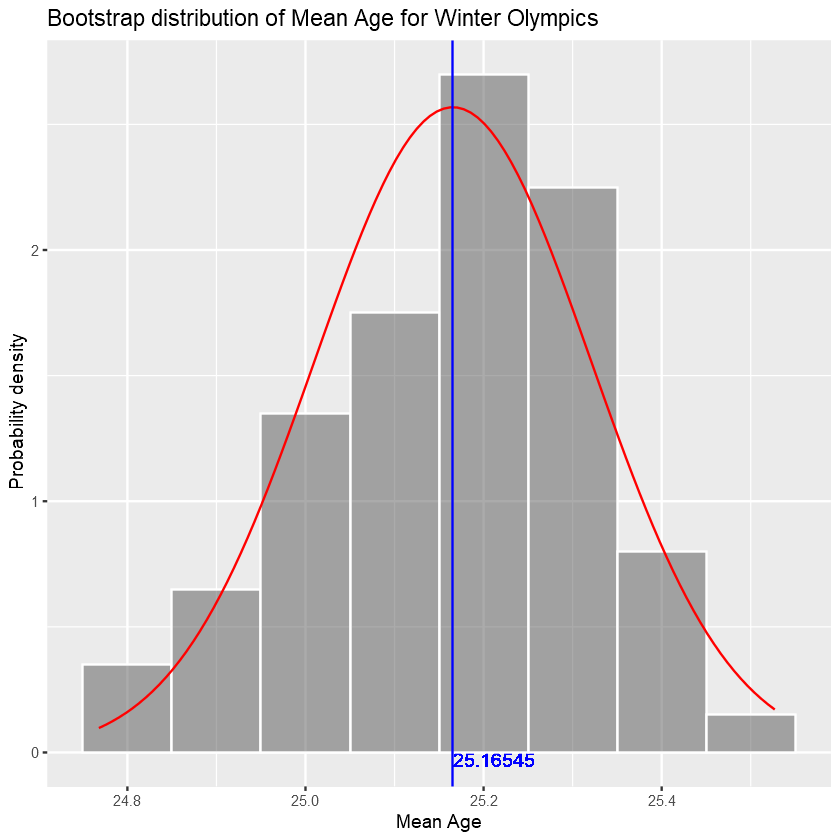

In [50]:
plot_histogram(winter_resampled_means, "mean_age", 0.1, TRUE) + 
    geom_vline(xintercept = winter_mean_estimate, color = "blue") + 
    labs(x="Mean Age", title="Bootstrap distribution of Mean Age for Winter Olympics")


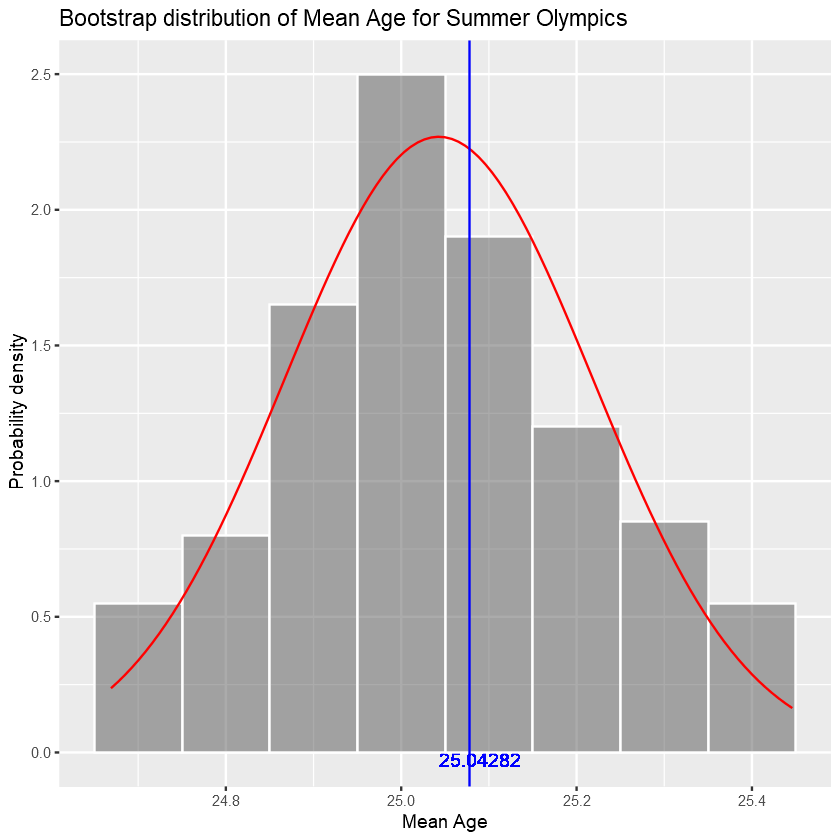

In [51]:
plot_histogram(summer_resampled_means, "mean_age", 0.1, TRUE) +
    geom_vline(xintercept = summer_mean_estimate, color = "blue") +
    labs(x="Mean Age", title="Bootstrap distribution of Mean Age for Summer Olympics")